In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set_theme(style="whitegrid")

BASE = "cricsheet_data/processed"

# Load CSVs
test_df = pd.read_csv(f"{BASE}/test.csv", low_memory=False)
odi_df  = pd.read_csv(f"{BASE}/ODI.csv",  low_memory=False)
t20_df  = pd.read_csv(f"{BASE}/T20.csv",  low_memory=False)
ipl_df  = pd.read_csv(f"{BASE}/IPL.csv",  low_memory=False)

# Add a format label to each
test_df["format"] = "Test"
odi_df["format"]  = "ODI"
t20_df["format"]  = "T20"
ipl_df["format"]  = "IPL"

all_df = pd.concat([test_df, odi_df, t20_df, ipl_df], ignore_index=True)

# A compact per-match dataframe (one row per match_id) for metadata-level charts
match_cols = ["match_id","format","season","city","venue","teams","toss_winner","toss_decision","winner","player_of_match"]
match_level = (all_df
               .sort_values("match_id")         # stable selection
               .drop_duplicates("match_id")[match_cols]
               .reset_index(drop=True))


### 1) Number of Matches Played per Season (All Matches)

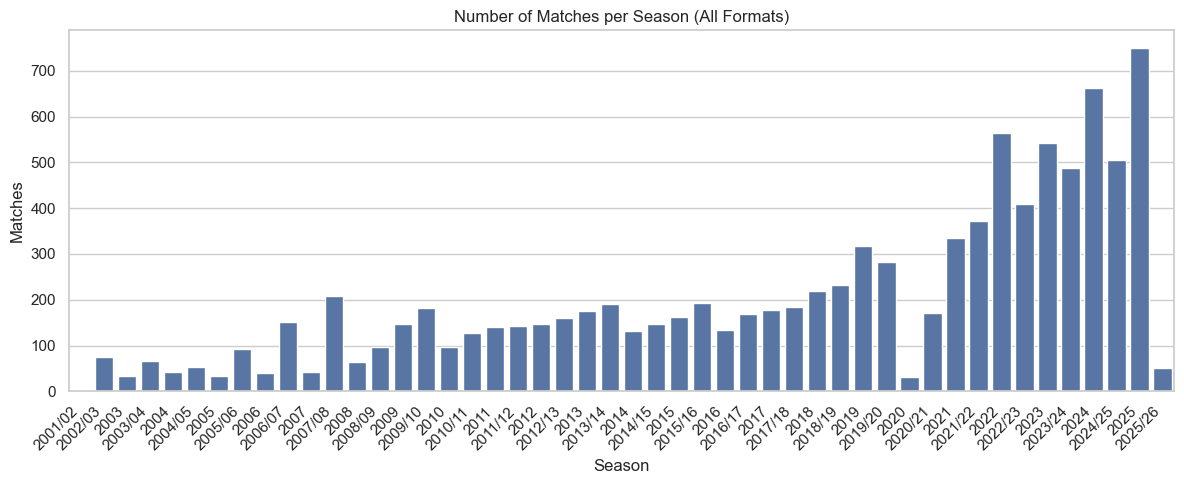

In [12]:
matches_per_season = (match_level
    .groupby("season", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"matches"}))

# Try to sort by numeric season when possible
matches_per_season["season_num"] = pd.to_numeric(matches_per_season["season"].str.extract(r"(\d{4})")[0], errors="coerce")
matches_per_season = matches_per_season.sort_values(["season_num","season"])

plt.figure(figsize=(12,5))
sns.barplot(data=matches_per_season, x="season", y="matches")
plt.title("Number of Matches per Season (All Formats)")
plt.xlabel("Season"); plt.ylabel("Matches")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()


### 2) Top 10 Most Frequent Venues (All Matches)

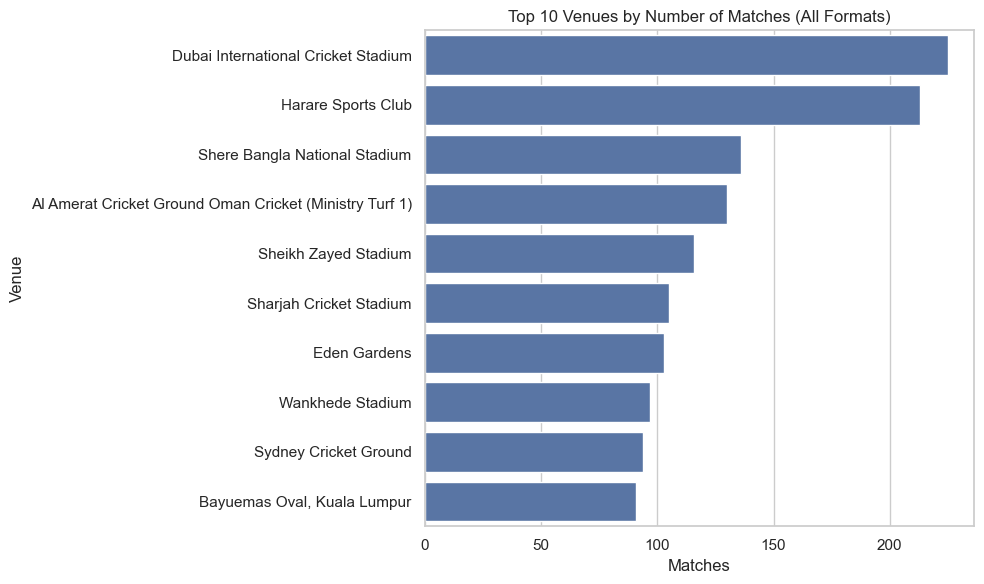

In [13]:
venue_counts = (match_level
    .groupby("venue", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"matches"})
    .sort_values("matches", ascending=False)
    .head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=venue_counts, x="matches", y="venue")
plt.title("Top 10 Venues by Number of Matches (All Formats)")
plt.xlabel("Matches"); plt.ylabel("Venue")
plt.tight_layout()


### 3) Toss Decision Distribution (ODI Matches)

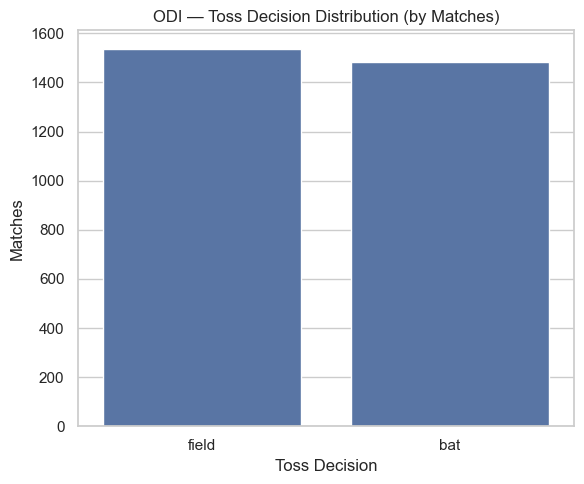

In [14]:
odi_toss = (odi_df
    .groupby("toss_decision", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"matches"}))

odi_toss["toss_decision"] = odi_toss["toss_decision"].fillna("Unknown").replace({"": "Unknown"})

plt.figure(figsize=(6,5))
sns.barplot(data=odi_toss, x="toss_decision", y="matches", order=odi_toss.sort_values("matches", ascending=False)["toss_decision"])
plt.title("ODI — Toss Decision Distribution (by Matches)")
plt.xlabel("Toss Decision"); plt.ylabel("Matches")
plt.tight_layout()


### 4) Distribution of Winners (Test Matches)

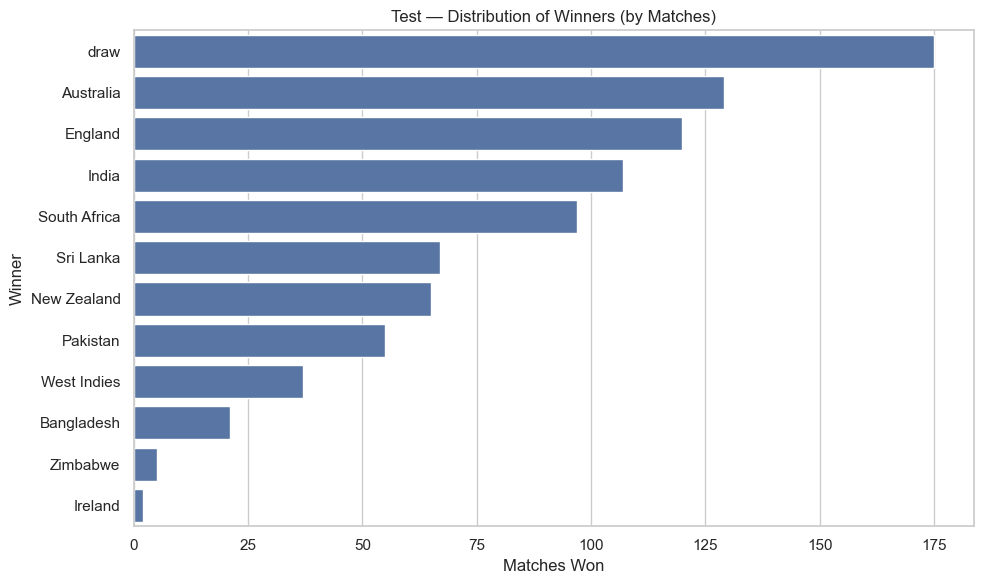

In [ ]:
test_winners = (test_df
    .groupby("winner", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"matches"})
    .sort_values("matches", ascending=False))

test_winners_top = test_winners.head(15)

plt.figure(figsize=(10,6))
sns.barplot(data=test_winners_top, x="matches", y="winner")
plt.title("Test — Distribution of Winners (by Matches)")
plt.xlabel("Matches Won"); plt.ylabel("Winner")
plt.tight_layout()


### 5) Runs Scored per Over (IPL Matches — Line Plot)

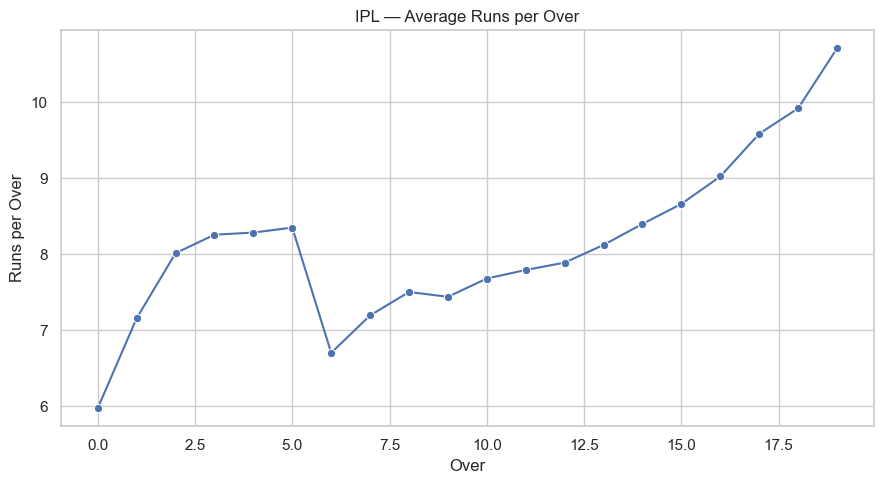

In [16]:
ipl_over = (ipl_df
    .groupby("over", as_index=False)["runs_total"]
    .mean()
    .rename(columns={"runs_total":"avg_runs_per_ball"}))

ipl_over["avg_runs_per_over"] = ipl_over["avg_runs_per_ball"] * 6

plt.figure(figsize=(9,5))
sns.lineplot(data=ipl_over, x="over", y="avg_runs_per_over", marker="o")
plt.title("IPL — Average Runs per Over")
plt.xlabel("Over"); plt.ylabel("Runs per Over")
plt.tight_layout()


### 6) Wickets Taken Distribution (T20 Matches)

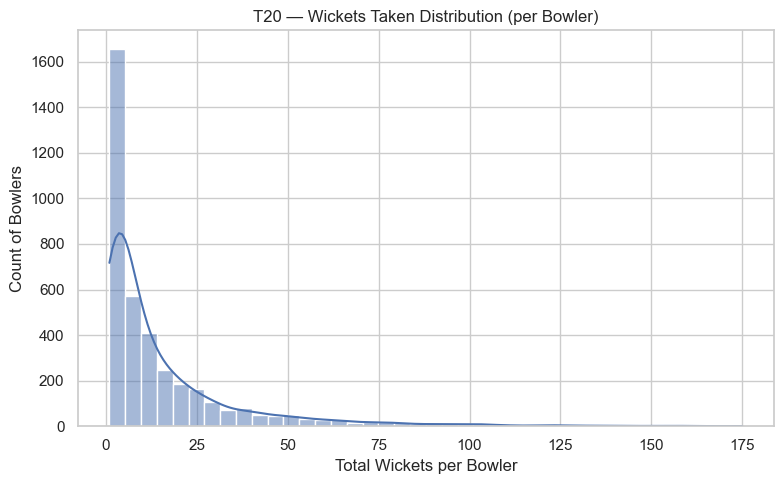

In [ ]:
t20_wkts = (t20_df.loc[t20_df["wicket"].notna() & (t20_df["wicket"] != "None")]
              .groupby("bowler", as_index=False)
              .size()
              .rename(columns={"size":"wickets"}))

plt.figure(figsize=(8,5))
sns.histplot(t20_wkts["wickets"], bins=40, kde=True)
plt.title("T20 — Wickets Taken Distribution (per Bowler)")
plt.xlabel("Total Wickets per Bowler"); plt.ylabel("Count of Bowlers")
plt.tight_layout()

### 7) Top 10 Toss Winners (All Matches)

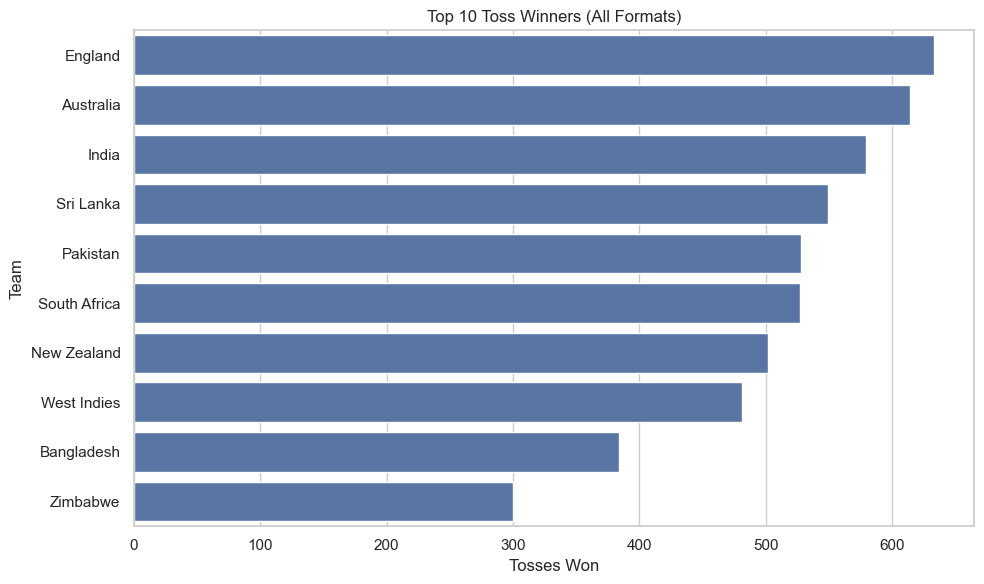

In [18]:
toss_winners = (match_level
    .groupby("toss_winner", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"tosses_won"})
    .sort_values("tosses_won", ascending=False)
    .head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=toss_winners, x="tosses_won", y="toss_winner")
plt.title("Top 10 Toss Winners (All Formats)")
plt.xlabel("Tosses Won"); plt.ylabel("Team")
plt.tight_layout()


### 8) City vs Number of Matches Played (Scatter — Plotly)

In [21]:
city_counts = (match_level
    .dropna(subset=["city"])
    .groupby("city", as_index=False)["match_id"]
    .nunique()
    .rename(columns={"match_id":"matches"})
    .sort_values("matches", ascending=False)
    .head(50))  # top 40 cities to keep it readable

fig = px.scatter(city_counts, x="matches", y="city",
                 size="matches", color="matches",
                 title="City vs Number of Matches Played (Top 10 Cities)",
                 labels={"matches":"Matches", "city":"City"})
fig.show()


### 9) IPL — Evolution of Scoring Pattern (Average Runs per Over by Season)

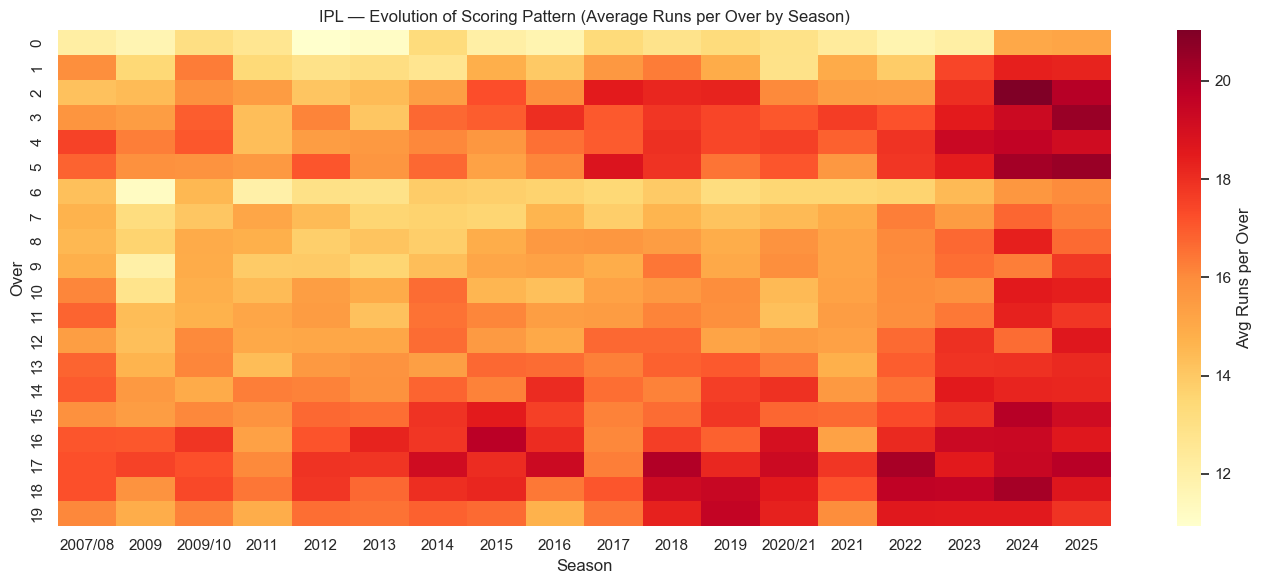

In [29]:
# Aggregate runs per over per match
ipl_over_runs = (ipl_df.groupby(["match_id","season","over"], as_index=False)["runs_total"]
                   .sum()
                   .rename(columns={"runs_total":"runs"}))

# Average runs per over by season
avg_over_season = (ipl_over_runs.groupby(["season","over"], as_index=False)["runs"]
                    .mean()
                    .rename(columns={"runs":"avg_runs"}))

# Use a numeric sort key but keep full season label for columns
avg_over_season["season_num"] = pd.to_numeric(
    avg_over_season["season"].str.extract(r"(\d{4})")[0], errors="coerce"
)

# Pivot using the original season label (not season_num)
pivot = avg_over_season.pivot_table(index="over", columns="season", values="avg_runs", aggfunc="mean")

# Order columns by season_num (first year), preserving full labels
order = (avg_over_season[["season","season_num"]]
         .drop_duplicates()
         .sort_values("season_num")["season"].tolist())

pivot = pivot.reindex(columns=order)

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="YlOrRd", cbar_kws={"label":"Avg Runs per Over"})
plt.title("IPL — Evolution of Scoring Pattern (Average Runs per Over by Season)")
plt.xlabel("Season"); plt.ylabel("Over")
plt.tight_layout()


### 10) Top 10 Player of the Match Winners (All Matches)

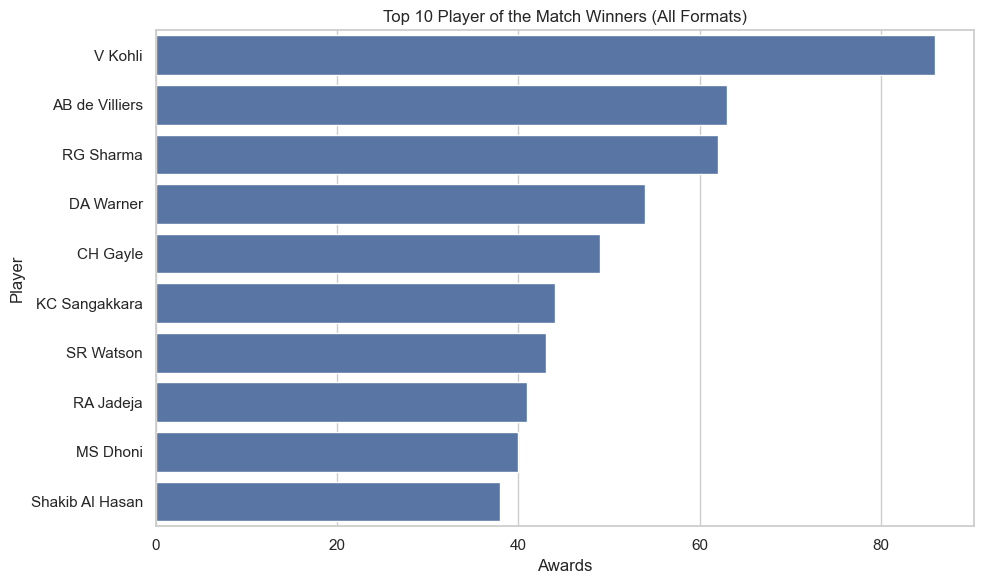

In [23]:
pom = (match_level[["match_id","player_of_match"]]
       .dropna(subset=["player_of_match"])
       .copy())

# split comma-separated names and explode
pom = (pom.assign(player_of_match=pom["player_of_match"].str.split(","))
          .explode("player_of_match"))
pom["player_of_match"] = pom["player_of_match"].str.strip()
pom = pom[pom["player_of_match"] != ""]  # remove blanks

pom_counts = (pom.groupby("player_of_match", as_index=False)["match_id"]
                .nunique()
                .rename(columns={"match_id":"awards"})
                .sort_values("awards", ascending=False)
                .head(10))

plt.figure(figsize=(10,6))
sns.barplot(data=pom_counts, x="awards", y="player_of_match")
plt.title("Top 10 Player of the Match Winners (All Formats)")
plt.xlabel("Awards"); plt.ylabel("Player")
plt.tight_layout()
